In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import groupby
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_absolute_error as mae

In [4]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_train.describe()

,ID,区域1,区域2,区域3,街道,房屋租金,服务费,供暖费用,电力基础价格,没有停车位,...,加热类型,房屋类型,邮政编码,房间数量,所处楼层,建筑楼层,最后翻新年份,建成年份,价格趋势,上传图片数
count,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,2.000000e+05,194878.000000,63507.000000,34806.000000,69183.000000,...,199881.000000,195799.000000,200000.000000,200000.000000,161736.000000,127329.000000,60166.000000,157522.000000,198679.00000,200000.000000
mean,99999.500000,5.11352,112.193435,1452.648445,8684.393950,7.050609e+02,150.694673,77.473713,89.115567,1.337482,...,2.383513,1.779018,1466.059120,2.638721,2.122106,3.573703,2013.928747,1966.374310,3.38789,9.789215
std,57735.171256,4.38307,102.461610,1570.143349,11463.243457,2.253782e+04,125.662569,161.982694,5.392918,9.362136,...,2.354078,2.481294,1383.885453,1.977911,3.731785,6.622676,10.551631,46.906557,1.96158,6.399923
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,71.430000,0.000000,...,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,1867.000000,1007.000000,-9.17000,0.000000
25%,49999.750000,1.00000,32.000000,307.000000,1.000000,3.381000e+02,95.000000,54.000000,90.760000,1.000000,...,1.000000,0.000000,365.000000,2.000000,1.000000,2.000000,2012.000000,1950.000000,2.00000,6.000000
50%,99999.500000,5.00000,74.000000,879.000000,3136.000000,4.900000e+02,135.000000,70.000000,90.760000,1.000000,...,1.000000,1.000000,1034.000000,3.000000,2.000000,3.000000,2017.000000,1973.000000,3.39000,9.000000
75%,149999.250000,8.00000,176.000000,2064.000000,13570.250000,7.990000e+02,190.000000,90.000000,90.760000,1.000000,...,3.000000,2.000000,2169.000000,3.000000,3.000000,4.000000,2019.000000,1996.000000,4.57000,13.000000
max,199999.000000,15.00000,418.000000,8225.000000,44189.000000,9.999999e+06,25000.000000,12613.000000,90.760000,2241.000000,...,12.000000,9.000000,7218.000000,560.000000,999.000000,999.000000,2919.000000,2090.000000,12.87000,121.000000


d:\Users\96212\anaconda3\envs\ML\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\96212\anaconda3\envs\ML\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\96212\anaconda3\envs\ML\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 34903 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\96212\anaconda3\envs\ML\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 36947 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\96212\anaconda3\envs\ML\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\96212\anaconda3\envs\ML\lib\site-packages\matplotlib\backends\backend_agg.py

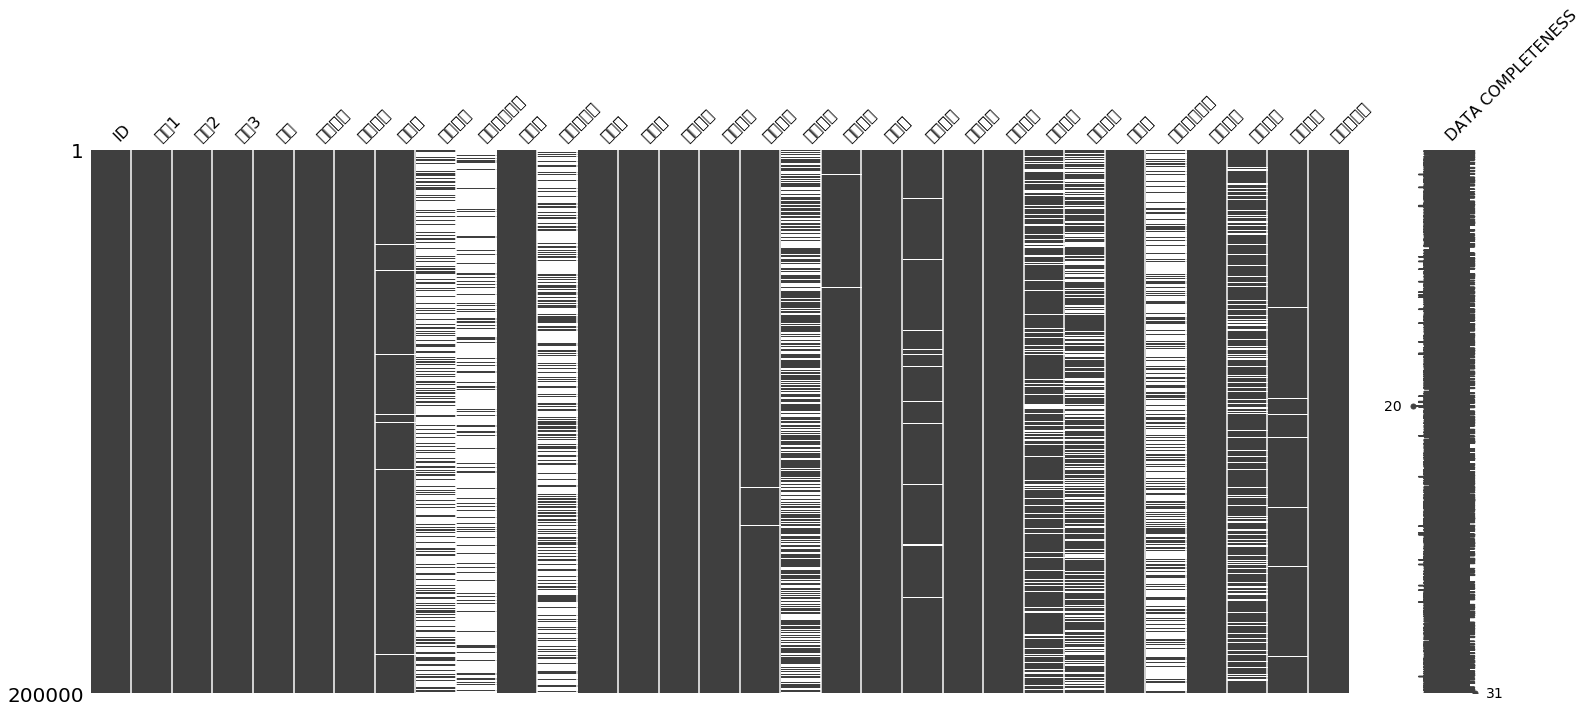

In [6]:
import missingno as msno
%matplotlib inline
msno.matrix(df_train, labels=True)
plt.savefig('t.jpg')

In [5]:
# 对缺失值进行填充
df_train.fillna(-1, inplace=True)
df_test.fillna(-1, inplace=True)

df_train.isnull().sum()

ID        0
区域1       0
区域2       0
区域3       0
街道        0
上传日期      0
房屋租金      0
服务费       0
供暖费用      0
电力基础价格    0
有阳台       0
没有停车位     0
有厨房       0
有地窖       0
居住面积      0
房屋状况      0
内饰质量      0
可带宠物      0
加热类型      0
有电梯       0
房屋类型      0
邮政编码      0
房间数量      0
所处楼层      0
建筑楼层      0
有花园       0
最后翻新年份    0
是新建筑      0
建成年份      0
价格趋势      0
上传图片数     0
dtype: int64

In [6]:
import re
# 对特征的类型进行处理
# 将上传日期变成年份和月份
upload_date = df_train['上传日期'].values
year_data = []
month_data = []
month_to_num = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 
                'May':5, 'Jun':6, 'Jul':7, 'Aug':8,
                'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
for i in upload_date:
    year_data.append(int(re.findall(r"[0-9]*[.]?[0-9]+", i)[0]))
    month_data.append(month_to_num[re.findall(r"[a-zA-Z]+\’*[a-z]*", i)[0]])

df_train['上传日期_年'] = year_data
df_train['上传日期_月'] = month_data
df_train.drop(columns=['上传日期'], inplace=True)

# 将特征值为布尔值变成数字
features_bool = ['有阳台', '有厨房', '有地窖', '有电梯', '有花园', '是新建筑']
df_train[features_bool] = df_train[features_bool].astype(int)

pet_dict = {'no':0, "yes":1, "negotiable":2}
pet_num = []
pet_bool = df_train['可带宠物'].values
for pet in pet_bool:
    if pet == -1:
        pet_num.append(-1)
    else:
        pet_num.append(pet_dict[pet])

df_train['可带宠物'] = pet_num

# 对测试集特征的类型进行处理
# 将上传日期变成年份和月份
upload_date = df_test['上传日期'].values
year_data = []
month_data = []
month_to_num = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 
                'May':5, 'Jun':6, 'Jul':7, 'Aug':8,
                'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
for i in upload_date:
    year_data.append(int(re.findall(r"[0-9]*[.]?[0-9]+", i)[0]))
    month_data.append(month_to_num[re.findall(r"[a-zA-Z]+\’*[a-z]*", i)[0]])

df_test['上传日期_年'] = year_data
df_test['上传日期_月'] = month_data
df_test.drop(columns=['上传日期'], inplace=True)

# 将特征值为布尔值变成数字
features_bool = ['有阳台', '有厨房', '有地窖', '有电梯', '有花园', '是新建筑']
df_test[features_bool] = df_test[features_bool].astype(int)

pet_dict = {'no':0, "yes":1, "negotiable":2}
pet_num = []
pet_bool = df_test['可带宠物'].values
for pet in pet_bool:
    if pet == -1:
        pet_num.append(-1)
    else:
        pet_num.append(pet_dict[pet])

df_test['可带宠物'] = pet_num


In [7]:
# 去除异常值
index_zero = df_train.loc[df_train['房屋租金'] == 0].index
print("房租价格等于0的数量有{0}".format(len(index_zero)))
df_train.drop(index = index_zero, inplace=True)
df_train = df_train.reset_index(drop=True)

index_zero_sq = df_train.loc[df_train['居住面积'] == 0].index
print("房租价格等于0的数量有{0}".format(len(index_zero_sq)))
df_train.drop(index = index_zero_sq, inplace=True)
df_train = df_train.reset_index(drop=True)

# 房屋租金这里的异常值，个人认为4000会比较好，但是由于一开始设置成了3000，所以目前以3000为基准进行测试
index_zero = df_train.loc[df_train['房屋租金'] > 3000].index
print("房租价格等于0的数量有{0}".format(len(index_zero)))
df_train.drop(index = index_zero, inplace=True)
df_train = df_train.reset_index(drop=True)

index_high = df_train.loc[df_train['居住面积'] > 300].index
print("房租价格超过50的数量有：{0}".format(len(index_high)))
df_train.drop(index = index_high, inplace=True)
df_train = df_train.reset_index(drop=True)

index_high = df_train.loc[df_train['服务费'] >750].index
print("房租价格超过50的数量有：{0}".format(len(index_high)))
df_train.drop(index = index_high, inplace=True)
df_train = df_train.reset_index(drop=True)


房租价格等于0的数量有68
房租价格等于0的数量有52
房租价格等于0的数量有997
房租价格超过50的数量有：45
房租价格超过50的数量有：64


In [8]:
df_train['房屋租金']

0          569.0
1          560.0
2          720.0
3          695.0
4         1200.0
           ...  
198769     220.0
198770     534.0
198771     225.0
198772    1142.0
198773     480.0
Name: 房屋租金, Length: 198774, dtype: float64

In [9]:
features = df_train.columns.drop(['ID','房屋租金'])
lgb_train = lgb.Dataset(df_train[features], df_train['房屋租金'])

param = {
    "seed":1111,
    "objective": "regression_l1",
    "learning_rate" : 0.1,
    'num_leaves': 256,
    "max_bin":512,
    'bagging_fraction': 0.7,
    'feature_fraction': 0.6,
    "metric": "mae",
    "boosting": "gbdt"}

model = lgb.cv(param, train_set=lgb_train, nfold=10, stratified=False, 
               num_boost_round=100, verbose_eval = 100,early_stopping_rounds=30,
               return_cvbooster=True,)
booster = model['cvbooster']

d:\Users\96212\anaconda3\envs\ML\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4693
[LightGBM] [Info] Number of data points in the train set: 178893, number of used features: 30
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4693
[LightGBM] [Info] Number of data points in the train set: 178893, number of used features: 30
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4693
[LightGBM] [Info] Number of data points in the train set: 178893, number of used features: 30
[LightGBM] [Warning] Auto-choosing col-wise multi-threadi

d:\Users\96212\anaconda3\envs\ML\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Start training from score 490.000000
[LightGBM] [Info] Start training from score 490.000000
[LightGBM] [Info] Start training from score 490.000000
[LightGBM] [Info] Start training from score 490.000000
[LightGBM] [Info] Start training from score 490.000000
[LightGBM] [Info] Start training from score 490.000000


KeyboardInterrupt: 

In [26]:
# 模型预测以及输出文件
test_pred = np.zeros(df_test.shape[0])

for model in booster.boosters:
    test_pred += model.predict(df_test[features]) / 10
    
df_test['房屋租金'] = test_pred
df_test[['ID', '房屋租金']].to_csv('submit/sublgb_16f_31_2000.csv', index=False, encoding='utf-8')